# Deeper KANs: [1, 1, 1, ..., 1] KANs

This is Part 2 of the tutorial series on KAN. In Part 1, we learned about the fundamental component of KANs that involves learning activation functions using B-splines.

In this tutorial, we will explore how to construct a network with such units and how to learn the coefficients. 
1. We will begin with a single input processed using two spline activation functions stacked on top of each other.
2. We will explore how to approach backpropagation through the stacked splines.

**Note:** The functions created in Part 1 have been copied in `utils.py`

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
from utils import eval_basis_functions

## Warm-up

Let's start by evaluating basis functions for some inputs and learn how to fit a function by determining the best coefficients to combine these basis functions.

**Caution:** We will be doing batch operations, so we must take care of indices. 
1. We expect x_eval to be ***number of samples x number of dimensions***
2. We expect grid to be ***number of activation functions x number of control points***. We consider only one activation function. 
3. We expect to receive output resembling ***number of samples x number of dimensions x number of basis functions***
4. So we expect coefficients to be ***number of dimensions x number of basis functions***

### Problem set-up
lean function $f(x)=sin(\pi*exp(x))$ using 2 order ot B-splines and 10 control points (augmented to exteded grid).
Generatre 20 observation points with noise ~ N(0,0.16)

In [2]:
# Let's see it in action
k = 2
x_eval = torch.linspace(-1, 1, steps=20).unsqueeze(dim=1) # each point is a sample
grid = torch.linspace(-1, 1, steps=10).unsqueeze(dim=0) # there is only one spline here 

bases = eval_basis_functions(x_eval, grid, k)
bases.shape

torch.Size([20, 1, 11])

Shapes:
Input bases: torch.Size([1, 20, 11])
Y_eval: torch.Size([1, 20, 1])
Ceofficients: torch.Size([1, 11, 1])


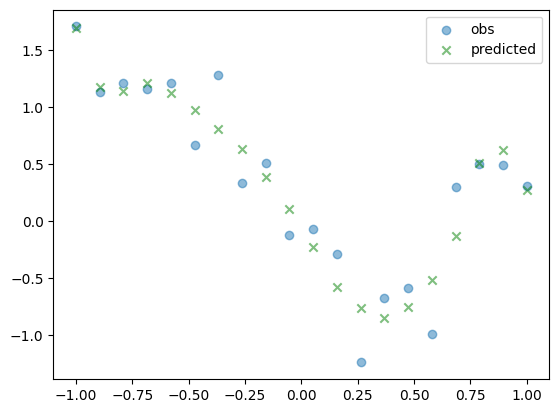

In [8]:
fn = lambda x: torch.sin(torch.pi * torch.exp(x))
y_eval = fn(x_eval) + torch.randn(x_eval.shape) * 0.4
# returns coeff for each dimension
coeff = torch.linalg.lstsq(bases.transpose(0, 1), y_eval.unsqueeze(dim=0)).solution # number of dimension x number of coefficients x 1
y_pred = torch.einsum('ijk, bij->bk', coeff, bases)
plt.scatter(x_eval[:, 0], y_eval[:, 0], alpha=0.5,label='obs')
plt.scatter(x_eval[:, 0], y_pred[:, 0], marker='x', color='green', alpha=0.5,label='predicted')
plt.legend()

print("Shapes:")
print(f"Input bases: {bases.transpose(0, 1).shape}")
print(f"Y_eval: {y_eval.unsqueeze(dim=0).shape}")
print(f"Ceofficients: {coeff.shape}")

## Diagramatic representations

KANs are defined by stacking various splines. 

Let's look at some basic possibilities - 

<img src="./images/kan-repr.png" width=750px></img>

KANs are represented as $[n_0, n_1, n_2, ..., n_l]$, where each number indicates the number of dimensions in that layer. For instance, the above diagram specifies $ n_0 $ dimensions in the input layer (which is pre-specified). It then describes $ n_1 $ dimensions in the second layer. Drawing an analogy with MLPs, $ n_1 $ represents the number of neurons in layer 1.

In the diagram above, we have the following architectures:
1. $ [1, 1] $: 1 input dimension mapped to 1 output dimension (Part 1 of the tutorial series).
2. $ [1, 1, 1] $: 1 input dimension mapped to 1 neuron in layer 1, which is then mapped to the output dimension.
3. $ [2, 1] $: Represents two input dimensions mapped to one output dimension.

All the neurons in KANs are formed by summing over the activations computed from the splines (read as transformations) of the previous layer's output.

**This approach is mathematically proposed in the Kolmogorov-Arnold Representation Theorem, which suggests that essentially, there is only one multivariate function, the addition operation ($f(x, y, z) = x + y + z$). All other functions are univariate functions, implying that any function of several variables can be decomposed into several univariate functions added together.** 

This principle underpins the ideology behind KAN networks. Imagine each neuron in a KAN network as a multivariable function of the previous layer, formed from adding the learned univariate activation functions.

**Caution:** Note that this theorem has only been proven for networks of the shape $[n, 2n+1, 1]$, indicating that the mathematical justification for deeper KANs is not yet proven.

In contrast, MLPs process their inputs differently. They multiply each dimension with a weight, sum the results, and then apply an activation function to produce a single neuron.

## Backpropagation to obtain the gradients of the coefficients

In this section, we derive the backpropagation rule for [1, 1, 1] KANs and demonstrate how to propagate errors back to the coefficients in the first layer. PyTorch's autograd functionality is particularly useful in computing the complex gradients of the basis functions.

Let's define the network operations:

- The first layer output, $ x' $, is calculated as:
  $ x' = \sum_{i=1}^{n} c_{0i} \cdot N_{0i}(x) $

- The predicted output, $ \hat{y} $, is:
  $ \hat{y} = \sum_{i=1}^{n} c_{1i} \cdot N_{1i}(x') $

- The loss function, $ \mathcal{L} $, is the L2 norm of the prediction error:
  $ \mathcal{L} = \|\hat{y} - y\|_2 $

- The gradient of $ \mathcal{L} $ with respect to the coefficients $ c_{1i} $ is:
$
\frac{\partial \mathcal{L}}{\partial c_{1i}} = \frac{\partial \mathcal{L}}{\partial \hat{y}} \times \frac{\partial \hat{y}}{\partial c_{1i}}
$

- For the coefficients $ c_{0i} $, the gradient is:
$
\frac{\partial \mathcal{L}}{\partial c_{0i}} = \frac{\partial \mathcal{L}}{\partial \hat{y}} \times \frac{\partial \hat{y}}{\partial x'} \times \frac{\partial x'}{\partial c_{0i}}
$,  where:
$
\frac{\partial \hat{y}}{\partial x'} = \sum_{i=1}^{n} c_{1i} \cdot \frac{\partial N_{1i}(x')}{\partial x'}
$

The derivatives of the basis functions, $ \frac{\partial N_{1i}(x')}{\partial x'} $, will be automatically computed through PyTorch’s autograd functionality, removing the need to manually derive the functional forms of these derivatives.

## Section 1: [1, 1, 1] KAN

Let's examine a network configuration where one spline is stacked on top of another, i.e., [1, 1, 1] KANs. We will explore learning various functions and observe the influence of specific factors.

For illustrative purposes, I've used two different grid sizes for each layer in the diagrams. However, the original implementation typically uses the same control points for all layers unless grid adaptation is applied, which we will discuss later.

In [9]:
def single_stacked_kan_training(x_training, y_training, x_test, y_test, model_params=None,lr=0.1, k=2, n_layers=2, grid_sizes=[], grid_ranges= [], early_stopping_imrpovement_threshold=200, early_stopping_iterations=1e4, verbose=False, grid_range=[-1, 1], use_scales=False):
    """
    Trains a KAN of shape [1, 1, 1, ...1] with `n_layers` layers. 
    Args:
        x_training: Training inputs; number of samples x number of input dimensions
        y_training: Training targets; number of samples x 1
        x_test: Test inputs; number of samples x number of input dimensions
        y_test: Test targets; number of samples x 1
        model_params: Parameters of the model. Used in the Part 3 of the tutorial to continue training from an existing set of parameters. 
        lr: learning rate
        k: spline-order
        n_layers: number of layers in the KAN
        grid_sizes: Number of control points for each spline in the stack, default is 10
        grid_ranges: Grid ranges for each spline in the stack, default is [-1,1]
        early_stopping_improvement_threshold: Number of iterations after which we can stop if there is no improvement in the validation loss
        early_stopping_iterations: Maximum number of iterations
        verbose: Whether to print the intermediate losses or not
        grid_range: Range of grids 
        use_scales: Whether to use the scaling parameters (see section 2. )
        
    """ 
    if grid_sizes == []:
        grid_sizes = [10] * n_layers

    if grid_ranges == []:
        grid_ranges = [[-1, 1]]* n_layers

    if not model_params:
        grids, coeffs, scale_bases, scale_splines, base_fns = [], [], [], [], []
        for idx in range(n_layers):
            grid = torch.linspace(grid_ranges[idx][0], grid_ranges[idx][1], steps=grid_sizes[idx]).unsqueeze(dim=0)
            grids.append(grid)
            
            coeff = torch.zeros((1, grid_sizes[idx] + k - 1, 1), requires_grad=True)
            coeffs.append(coeff)
    
            if use_scales:
                base_fn = torch.nn.SiLU()
                scale_base = torch.nn.Parameter(torch.ones(x_eval.shape[-1])).requires_grad_(True)
                scale_spline = torch.nn.Parameter(torch.ones(x_eval.shape[-1])).requires_grad_(True)
    
                scale_bases.append(scale_base)
                scale_splines.append(scale_spline)
                base_fns.append(base_fn)
    else:
        grids = model_params['grids']
        coeffs = model_params['coeffs']
        scale_bases = model_params['scale_bases']
        scale_splines = model_params['scale_splines']
        base_fns = model_params['base_fns']
    
    
    losses = {'train': [], 'val': []}
    best_loss = np.inf
    n_no_improvements = 0
    i = 0
    all_xs = []
    while True:    
        x = x_training
        xs = []
        for idx in range(n_layers):
            bases = eval_basis_functions(x, grids[idx], k)
            x_ = torch.einsum('ijk, bij->bk', coeffs[idx], bases)
            if use_scales:
                base_transformed_x = base_fns[idx](x) # transformation of the original x
                x = base_transformed_x * scale_bases[idx] + x_ * scale_splines[idx]
            else:
                x = x_

            xs.append(x.detach())

        all_xs.append(xs)
    
        y_pred = x
        loss = torch.mean(torch.pow(y_pred - y_training, 2))
        loss.backward()
        losses['train'].append(loss.item())

        # Gradient descent step
        for params in coeffs + scale_bases + scale_splines:
            params.data = params.data - lr * params.grad
            params.grad.zero_()

        # evaluate validation loss
        with torch.no_grad():
            x = x_test
            for idx in range(n_layers):
                bases = eval_basis_functions(x, grids[idx], k)
                x_ = torch.einsum('ijk, bij->bk', coeffs[idx], bases)
                if use_scales:
                    base_transformed_x = base_fns[idx](x) # transformation of the original x
                    x = base_transformed_x * scale_bases[idx] + x_ * scale_splines[idx]
                else:
                    x = x_
            y_pred_test = x
            val_loss = torch.mean(torch.pow(x - y_test, 2))
            
            losses['val'].append(val_loss.item())

        if i% 100 == 0 and verbose:
            print(f"Val loss: {val_loss.item(): 0.5f}\tTrain loss: {loss.item(): 0.5f}\tBest Val loss:{best_loss: 0.5f}")
            
        if best_loss > val_loss.item():
            best_loss = val_loss.item()
            best_model = (coeffs, base_fns, scale_bases, scale_splines)
            n_no_improvements = 0
        else:
            n_no_improvements += 1
            if n_no_improvements > early_stopping_imrpovement_threshold:
                print('Stopping: No further improvements...')
                break
    
        i += 1
        if i > early_stopping_iterations:
            print('Stopping: Iteration limit reached...')
            break       

    model_params = {
        'grids': grids,
        'coeffs': best_model[0],
        'scale_bases':  best_model[2],
        'scale_splines':  best_model[3],
        'base_fns': best_model[1],
    }
    return model_params, y_pred_test, losses, all_xs

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_66517/1235572522.py:2: SyntaxWarning: invalid escape sequence '\p'
  fns += [(lambda x: torch.sin(torch.pi* torch.exp(x)), '$f(x) = sin(\pi*e^{x})$')]
/tmp/ipykernel_66517/1235572522.py:3: SyntaxWarning: invalid escape sequence '\p'
  fns += [(lambda x: torch.exp(torch.sin(torch.pi* x) + x**2) + (1 / (1 + x**2)), '$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$')]


$f(x) = sin(\pi*e^{x})$
Number of observations in the training dataset:  799
Number of observations in the test dataset:  438
Stopping: No further improvements...
$f(x) = sin(\pi*e^{x})$	Avg. loss:  0.01188
$f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$
Number of observations in the training dataset:  799
Number of observations in the test dataset:  448
Stopping: No further improvements...
$f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$	Avg. loss:  0.05256


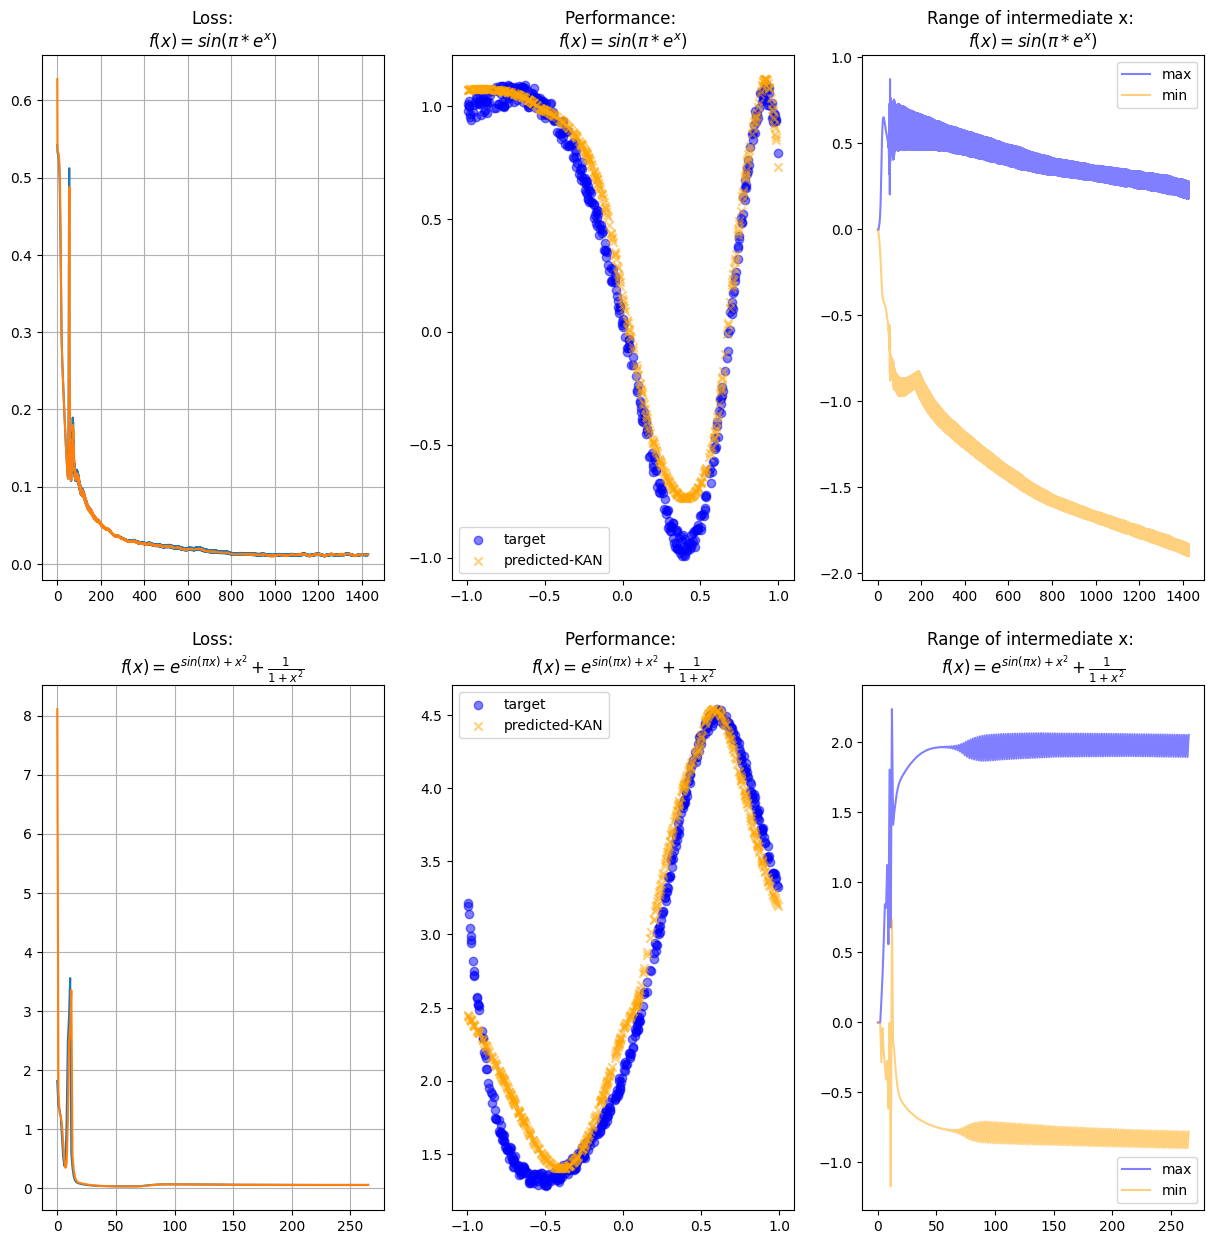

In [10]:
fns = []
fns += [(lambda x: torch.sin(torch.pi* torch.exp(x)), '$f(x) = sin(\pi*e^{x})$')]
fns += [(lambda x: torch.exp(torch.sin(torch.pi* x) + x**2) + (1 / (1 + x**2)), '$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$')]

lr = 0.1
k = 3
n_layers = 2
grid_sizes = [3, 3]
grid_range = [-1, 1]

fig, axs = plt.subplots(nrows=len(fns), ncols=3, figsize=(15, 15), dpi=100)
for idx, (fn, fn_label) in enumerate(fns):
    x_eval = torch.linspace(-1, 1, steps=999).unsqueeze(dim=1)
    y_target = fn(x_eval) + 0.1 * torch.rand(x_eval.shape)

    # test and train split
    n_training = int(x_eval.shape[0] * 0.8)
    training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
    test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]
    x_training = x_eval[training_idxs]
    x_test = x_eval[test_idxs]
    y_training = y_target[training_idxs]
    y_test = y_target[test_idxs]

    print(fn_label)
    print("Number of observations in the training dataset: ", n_training)
    print("Number of observations in the test dataset: ", len(test_idxs))


    params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(x_training, y_training, x_test, y_test, lr=lr, 
                                                                             k=k, n_layers=n_layers, 
                                                                             grid_sizes=grid_sizes, verbose=False, 
                                                                             grid_range=grid_range)
    print(f"{fn_label}\tAvg. loss: {np.mean(losses_kan['val'][-100:]): 0.5f}")

    ax = axs[idx, 0]
    ax.plot(losses_kan['val'], label='val')
    ax.plot(losses_kan['train'], label='train')
    ax.grid()
    ax.set_title(f"Loss:\n{fn_label}")

    ax = axs[idx, 1]
    ax.scatter(x_test[:, 0].tolist(), y_test[:, 0].tolist(), color='blue', alpha=0.5, label='target')
    ax.scatter(x_test[:, 0].tolist(), y_pred_kan[:, 0].tolist(), color='orange', alpha=0.5, label='predicted-KAN', marker='x')
    ax.legend()
    ax.set_title(f"Performance: \n{fn_label}")

    ax = axs[idx, 2]
    x_min = [xs[0].min().item() for xs in all_xs]
    x_max = [xs[0].max().item() for xs in all_xs]
    ax.plot(x_max, color='blue', alpha=0.5, label='max')
    ax.plot(x_min, color='orange', alpha=0.5, label='min')
    ax.legend()
    ax.set_title(f"Range of intermediate x: \n{fn_label}")
    


**Note:**

We've analyzed the output of the first spline to gauge the minimum and maximum values of this layer. It is observed that the maximum value occasionally exceeds 1, falling outside the expected domain. Thus, it illustrates how intermediate values can sometimes extend beyond their intended range.

Let's look at the solutions to prevent this scenario.


## Section 2: Scaling the activation function

To ensure that these intermediate values remain well-defined and contribute effectively to the gradients, we might consider two strategies:

1. **Extend the Grid Range**: Define a broader `grid_range`, such as `[-2, 2]`, and observe whether this prevents intermediate values from exceeding the domain limits.
2. **Implement Learnable Scaling Parameters**: This approach involves using scaling parameters that can be adjusted to keep intermediate values within the domain. This method is favored by the authors as it provides a more robust solution.

The implementation is as follows:

$$
\phi(x) = w \cdot (b(x) + \sum_{i=0}^{n}c_i \cdot N_{i}(x))
$$

In this formula, the output of the spline activation is first adjusted by a bias parameter $ b(x) $, and then the sum is scaled by a learnable factor $ w $. These modifications are designed to prevent the intermediate neurons from exceeding their domain by suitably adjusting the learnable parameters.

Next, let’s explore these two options in practice when the function is $f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$.

Scales: False, Range:[-1, 1]
Number of observations in the training dataset:  799
Number of observations in the test dataset:  456
Stopping: No further improvements...
$f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$	Avg. loss:  0.04866
Scales: False, Range:[-2, 2]
Number of observations in the training dataset:  799
Number of observations in the test dataset:  456
Stopping: Iteration limit reached...
$f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$	Avg. loss:  0.00535
Scales: True, Range:[-1, 1]
Number of observations in the training dataset:  799
Number of observations in the test dataset:  456
Stopping: No further improvements...
$f(x) = e^{sin(\pi x) + x^2} + \frac{1}{1+x^2}$	Avg. loss:  0.00495


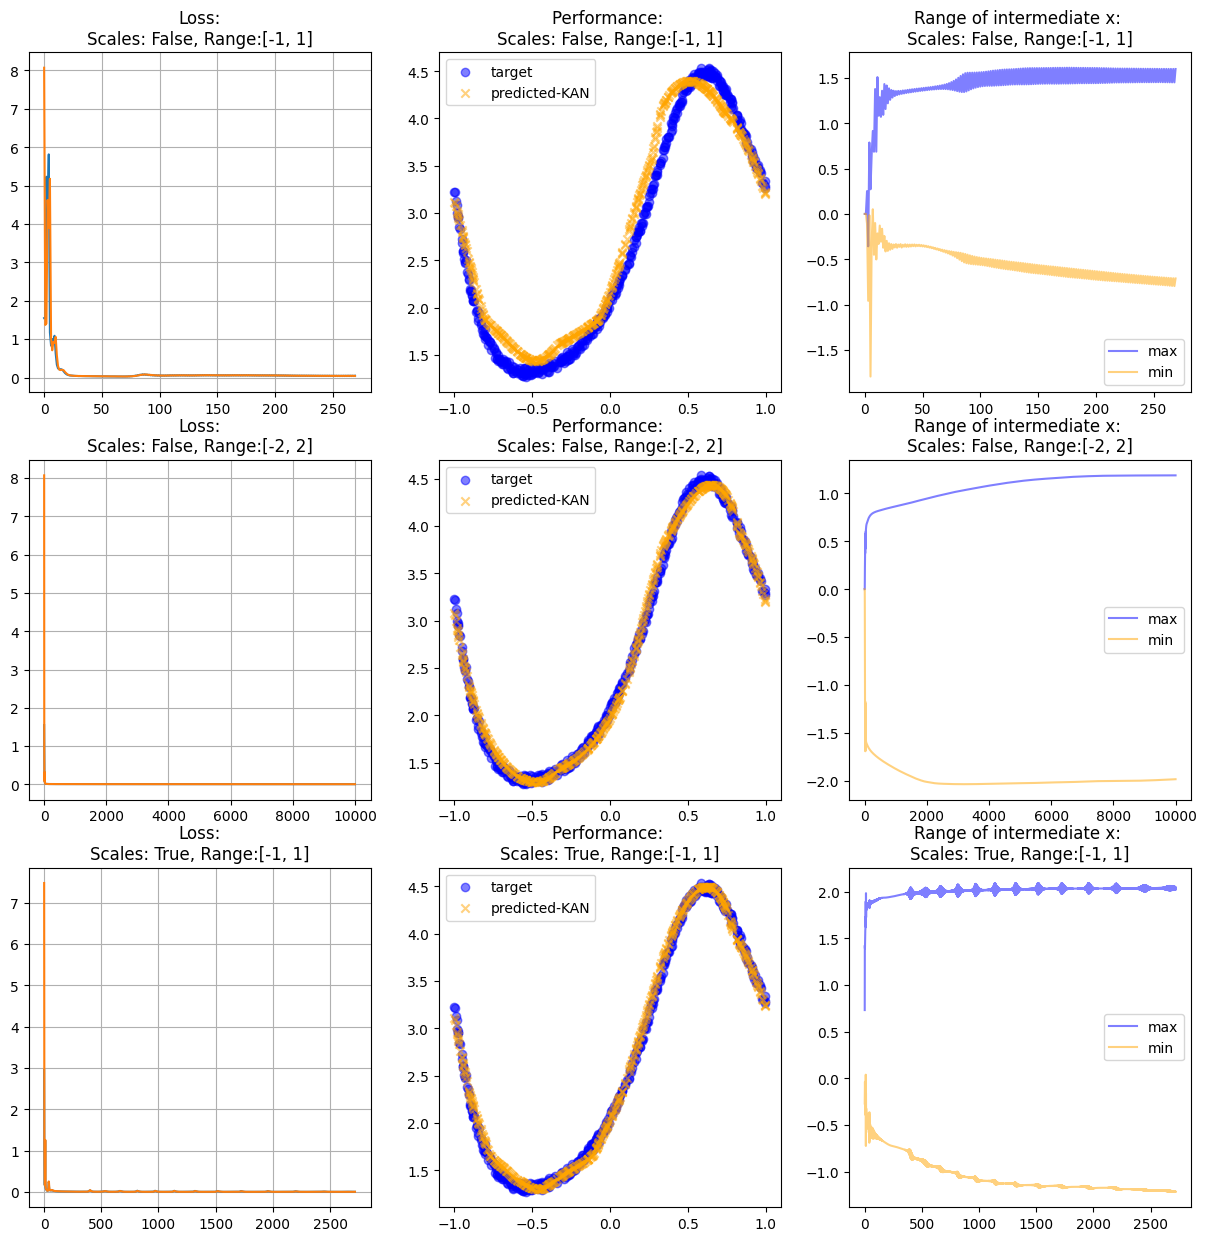

In [66]:
fn, fn_label = (lambda x: torch.exp(torch.sin(torch.pi* x) + x**2) + (1 / (1 + x**2)), '$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$')
use_scales = [True, False]


x_eval = torch.linspace(-1, 1, steps=999).unsqueeze(dim=1)
y_target = fn(x_eval) + 0.1 * torch.rand(x_eval.shape)

# test and train split
n_training = int(x_eval.shape[0] * 0.8)
training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]
x_training = x_eval[training_idxs]
x_test = x_eval[test_idxs]
y_training = y_target[training_idxs]
y_test = y_target[test_idxs]

params = [
    (dict(use_scales=False, grid_ranges=[[-1,1], [-1, 1]]), 'Scales: False, Range:[-1, 1]'),
    (dict(use_scales=False, grid_ranges=[[-1,1], [-2, 2]]), 'Scales: False, Range:[-2, 2]'),
    (dict(use_scales=True, grid_ranges=[[-1,1], [-1, 1]]), 'Scales: True, Range:[-1, 1]'),
]

lr = 0.1
k = 3
n_layers = 2
grid_sizes = [4, 4]

fig, axs = plt.subplots(nrows=len(params), ncols=3, figsize=(15, 15), dpi=100)
final_losses = []
for idx, param in enumerate(params):
    label = param[1]
    print(label)
    print("Number of observations in the training dataset: ", n_training)
    print("Number of observations in the test dataset: ", len(test_idxs))


    params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(x_training, y_training, x_test, y_test, lr=lr, 
                                                                             k=k, n_layers=n_layers, 
                                                                             grid_sizes=grid_sizes, verbose=False, 
                                                                             **param[0])
    print(f"{fn_label}\tAvg. loss: {np.mean(losses_kan['val'][-100:]): 0.5f}")

    final_losses.append((label, np.mean(losses_kan['val'][-100:])))

    ax = axs[idx, 0]
    ax.plot(losses_kan['val'], label='val')
    ax.plot(losses_kan['train'], label='train')
    ax.grid()
    ax.set_title(f"Loss:\n{label}")

    ax = axs[idx, 1]
    ax.scatter(x_test[:, 0].tolist(), y_test[:, 0].tolist(), color='blue', alpha=0.5, label='target')
    ax.scatter(x_test[:, 0].tolist(), y_pred_kan[:, 0].tolist(), color='orange', alpha=0.5, label='predicted-KAN', marker='x')
    ax.legend()
    ax.set_title(f"Performance: \n{label}")

    ax = axs[idx, 2]
    x_min = [xs[0].min().item() for xs in all_xs]
    x_max = [xs[0].max().item() for xs in all_xs]
    ax.plot(x_max, color='blue', alpha=0.5, label='max')
    ax.plot(x_min, color='orange', alpha=0.5, label='min')
    ax.legend()
    ax.set_title(f"Range of intermediate x: \n{label}")
    


In [67]:
for label, loss in final_losses:
    print(f"{label}: {loss: 0.5f}")

Scales: False, Range:[-1, 1]:  0.04866
Scales: False, Range:[-2, 2]:  0.00535
Scales: True, Range:[-1, 1]:  0.00495


**Observations:**

- Grid range of $ [-1, 1] $ *without* the scaling parameters has the maximum loss value compared to the other cases
- Extending the grid range to $ [-2, 2] $ is as effective as using scales in the grid range of $ [-1, 1] $.

Given the unpredictable ranges of intermediate neuron outputs, employing scaling parameters is a practical approach. Specifically, scaling aids in stabilizing the training process, as these parameters help control the domain of the outputs. This control is crucial in preventing outputs from exceeding domain limits, which could otherwise impede learning.

## Section 3: How does it compare to MLPs?

Finally, let's look at the comparable sized MLP and how it performs compared to KAN above.

In [72]:
def single_stacked_mlp_training(x_training, y_training, x_test, y_test, lr, layer_sizes, early_stopping_imrpovement_threshold=200, early_stopping_iterations=1e4, verbose=True):
    """Trains MLP similar to the function above."""
    
    layer_sizes = [1] + layer_sizes + [1]
    weights, biases = [], []
    n_layers = len(layer_sizes)

    # Define MLP weights and biases
    for idx in range(n_layers-1):
        w = torch.randn(layer_sizes[idx], layer_sizes[idx+1], requires_grad=True)
        weights.append(w)
    
        b = torch.zeros(layer_sizes[idx+1], requires_grad=True)
        biases.append(b)

    losses = {'train': [], 'val': []}
    best_loss = np.inf
    n_no_improvements = 0
    i = 0
    while True:
        x = x_eval
        for weight, bias in zip(weights, biases):
            x = F.linear(x, weight.t(), bias)
            x = F.silu(x) # relu might not work better here
        
        y_pred = x
        loss = torch.mean(torch.pow(y_pred - y_target, 2))
        loss.backward()
        losses['train'].append(loss.item())

        # Perform gradient descent
        for weight, bias in zip(weights, biases):
            weight.data = weight.data - lr * weight.grad
            weight.grad.zero_()
        
            bias.data = bias.data - lr * bias.grad
            bias.grad.zero_()

        # evaluate validation loss
        with torch.no_grad():
            x = x_test
            for weight, bias in zip(weights, biases):
                x = F.linear(x, weight.t(), bias)
                x = F.silu(x) # relu might not work better here
            y_pred_test = x
            val_loss = torch.mean(torch.pow(x - y_test, 2))
            losses['val'].append(val_loss.item())

        if i% 100 == 0 and verbose:
            print(f"Val loss: {val_loss.item(): 0.5f}\tTrain loss: {loss.item(): 0.5f}\tBest Val loss:{best_loss: 0.5f}")
            
        if best_loss > val_loss.item():
            best_loss = val_loss.item()
            best_model = [weights, biases]
            n_no_improvements = 0
        else:
            n_no_improvements += 1
            if n_no_improvements > early_stopping_imrpovement_threshold:
                print('Stopping: No further improvements...')
                break
    
        i += 1
        if i > early_stopping_iterations:
            print('Stopping: Iteration limit reached...')
            break       


    return best_model, y_pred_test, losses
        


In [ ]:
# Create a dataset
fn, fn_label = (lambda x: torch.exp(torch.sin(torch.pi* x) + x**2) + (1 / (1 + x**2)), '$f(x) = e^{sin(\pi x) + x^2} + \\frac{1}{1+x^2}$')

x_eval = torch.linspace(-1, 1, steps=999).unsqueeze(dim=1)
y_target = fn(x_eval) + 0.1 * torch.rand(x_eval.shape)

# test and train split
n_training = int(x_eval.shape[0] * 0.8)
training_idxs = np.random.randint(x_eval.shape[0], size=n_training)
test_idxs = [i for i in range(x_eval.shape[0]) if i not in training_idxs]
x_training = x_eval[training_idxs]
x_test = x_eval[test_idxs]
y_training = y_target[training_idxs]
y_test = y_target[test_idxs]


In [83]:
# train [1, 1, 1] KAN
use_scales = False
grid_sizes = [5, 5]
grid_ranges = []
n_layers = 2
lr = 0.1
k = 3

params_kan, y_pred_kan, losses_kan, all_xs = single_stacked_kan_training(x_training, y_training, x_test, y_test, lr=lr, 
                                                                         k=k, n_layers=n_layers, 
                                                                         grid_sizes=grid_sizes, verbose=False, 
                                                                         grid_ranges=[], use_scales=use_scales)

print(f"Number of params: {sum([x.numel() for x in params_kan['coeffs']])}")
print(f"Avg. loss: {np.mean(losses_kan['val'][-100:]): 0.5f}")

Stopping: No further improvements...
Number of params: 14
Avg. loss:  0.00577


In [87]:
# MLP training 
lr = 0.1
layer_sizes = [3, 3] 

params_mlp, y_pred_mlp, losses_mlp = single_stacked_mlp_training(x_training, y_training, x_test, y_test, lr=lr, layer_sizes=layer_sizes, verbose=False)
weights, biases = params_mlp

print(f"Number of parameters learned: {sum([x.numel() for x in weights]) + sum([x.numel() for x in biases])}")
print(f"Avg. loss: {np.mean(losses_mlp['val'][-100:]): 0.5f}")

Stopping: No further improvements...
Number of parameters learned: 22
Avg. loss:  0.06915


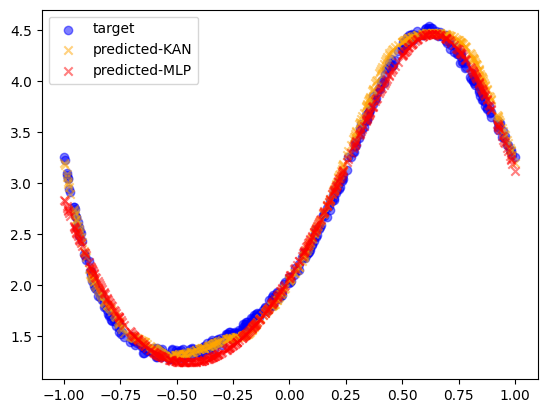

In [80]:
plt.scatter(x_test[:, 0].tolist(), y_test[:, 0].tolist(), color='blue', alpha=0.5, label='target')
plt.scatter(x_test[:, 0].tolist(), y_pred_kan[:, 0].tolist(), color='orange', alpha=0.5, label='predicted-KAN', marker='x')
plt.scatter(x_test[:, 0].tolist(), y_pred_mlp[:, 0].tolist(), color='red', alpha=0.5, label='predicted-MLP', marker='x')
plt.legend()

**Observations:**

The MLP for the same number of parameters yields inferior loss compared to KAN of similar size. However, there might exist some hyperparameters for MLP training yielding similar or better performance as KAN. 

**To summarize:**

- We have explored how to learn the coefficients in KAN by backpropagating errors.
- We observed the benefits of implementing scaling functions alongside spline activations.
- We assessed and compared the performance with that of MLPs.

**What's next?**

In the next notebook, we will learn how to manipulate grid or control points to facilitate continual learning. This approach also allows for ongoing learning without the need to retrain the network, all made possible through the use of spline-activation functions.

### FINISH

Now, what will happen when instead of increasing the domain, we increase the control points in the same grid range? i.e., we make the grid finer --> This has the same impact as increasing the number of parameters, which is what we did by using the scales. 

As authors mention, increasing the number of grid points result in the increase in the number of parameters. One exceptional quality of such a method is that the network need not be retrained -- one can use the existing learned parameters and keep training from thereon. 

Let's look at what will happen in the above learning curves, when the grid is made finer instead of increasing the range or using scales?



## Updating the control points to accomadate shifting domains of intermediate neurons

In updating the control points we need two thigns - 

1. new control points (i.e., new grid)
2. the corresponding coefficients


Here, we are constrained by the following requirements -

1. New control points are determined using the new sample (keeping the number of intervals same, hence the number of coefficients will be same)
2. New coefficients are chosen to keep the predictions same but using the new control points

In [331]:
def get_coeff(bases, y_eval):
    """
    Returns coefficients that give y_eval from bases

    Args:
        bases: number of samples x number of basis functions
        y_eval: number of samples x 1
        
    """
    return torch.linalg.lstsq(bases.transpose(0, 1), y_eval.unsqueeze(dim=0)).solution

In [517]:
eval_basis_functions(x_pos, grid2, k).shape, grid2.shape, coeff2.shape

(torch.Size([1, 10, 6]), torch.Size([1, 10]), torch.Size([1, 6, 1]))

In [356]:
grid_eps = 0.02
x1, x2 = all_xs[-1]
grid2 = grids[1]
coeff2 = coeffs[1]

batch = x1.shape[0]
x_pos = torch.sort(x1, dim=0)[0]
y_eval = torch.einsum('ijk, bij->bk', coeff2, eval_basis_functions(x_pos, grid2, k)*1.0)

num_intervals = grid2.shape[-1] - 1
ids = [int(batch / num_intervals * i) for i in range(num_intervals)] + [-1] # last index is chosen as is for the boundary

grid_adaptive = x_pos[ids, :].transpose(1, 0)
grid_range = grid_adaptive[:, [-1]] - grid_adaptive[:, [0]]
margin = 0.01
grid_uniform = torch.cat([grid_adaptive[:, [0]] - margin + (grid_range + 2*margin)*a for a in torch.linspace(0, 1, num_intervals + 1)], dim=1)

new_grid = grid_uniform * grid_eps + grid_adaptive * (1 - grid_eps)
# grid2 = grid_adaptive
new_bases = eval_basis_functions(x_pos, new_grid, k)
new_coeff = get_coeff(new_bases, y_eval)
# torch.linalg.lstsq(new_bases.transpose(0, 1), y_eval.unsqueeze(dim=0)).solution
new_coeff.data

tensor([[[-0.0011],
         [ 0.0047],
         [-0.0051],
         [ 0.0042],
         [-0.0296],
         [ 0.1378]]])

In [367]:
def update_grids(grids, coeffs, all_xs, grid_eps=0.02, margin=0.01):
    """
    Updates grids. 
    """
    
    n_xs = len(all_xs)
    for i in range(n_xs-1):
        x = all_xs[i]
        grid = grids[i+1] # ith index is input to the grid at i+1
        coeff = coeffs[i+1]
        
        
        x_pos = torch.sort(x, dim=0)[0]
        y_eval = torch.einsum('ijk, bij->bk', coeff, eval_basis_functions(x_pos, grid, k))

        batch = x.shape[0]
        num_intervals = grid.shape[-1] - 1
        ids = [int(batch / num_intervals * i) for i in range(num_intervals)] + [-1] # last index is chosen as is for the boundary

        # grid to have equal number of observations in each bucket
        grid_adaptive = x_pos[ids, :].transpose(1, 0)

        # uniform grid with equally spaced control points
        grid_range = grid_adaptive[:, [-1]] - grid_adaptive[:, [0]]
        grid_uniform = torch.cat([grid_adaptive[:, [0]] - margin + (grid_range + 2*margin)*a for a in torch.linspace(0, 1, num_intervals + 1)], dim=1)
        
        new_grid = grid_uniform * grid_eps + grid_adaptive * (1 - grid_eps)
        new_bases = eval_basis_functions(x_pos, new_grid, k)
        new_coeff = get_coeff(new_bases, y_eval)

        grid.data = new_grid.data
        coeff.data = new_coeff.data

    return grids, coeffs

        

In [562]:
update_grid = False
grid_update_freq = 50 #  backprop iterations
stop_grid_update_step = np.inf # don't update after these many iterations

fn = lambda x: torch.sin(torch.pi* torch.exp(x)) + torch.tanh(x) + torch.arcsinh(x)
x_eval = torch.linspace(-1, 1, steps=999).unsqueeze(dim=1)
y_target = fn(x_eval) + 0.1 * torch.rand(x_eval.shape)

lr = 0.5
n_layers = 2
grid_range = [-1, 1]
grid_sizes = [10, 10]

grids, coeffs = [], []
for idx in range(n_layers):
    grid = torch.linspace(grid_range[0], grid_range[1], steps=grid_sizes[idx]).unsqueeze(dim=0)
    grids.append(grid)
    
    coeff = torch.zeros((1, grid_sizes[idx] - k - 1, 1), requires_grad=True)
    coeffs.append(coeff)

verbose = True
early_stopping_threshold = 200
losses = []
best_loss = np.inf
n_no_improvements = 0
i = 0
all_xs = []
all_grads = []
grid_updates = []
while True:    
    x = x_eval
    xs = []
    for idx in range(n_layers):
        bases = eval_basis_functions(x, grids[idx], k)
        x = torch.einsum('ijk, bij->bk', coeffs[idx], bases)
        xs.append(x.detach())

    all_xs.append(xs)

    y_pred = x
    loss = torch.mean(torch.pow(y_pred - y_target, 2))
    loss.backward()
    losses.append(loss.item())
    
    if i% 100 == 0 and verbose:
        print(loss.item())
    
    if best_loss > loss.item():
        best_loss = loss.item()
        n_no_improvements = 0
    else:
        n_no_improvements += 1
        if n_no_improvements > early_stopping_threshold:
            break

    grads = []
    for coeff in coeffs:
        coeff.data = coeff.data - lr * coeff.grad
        grads.append(coeff.grad.norm())
        coeff.grad.zero_()
    all_grads.append(grads)

    if update_grid and i%grid_update_freq == 0 and i < stop_grid_update_step:
    # if  0.01 < grids[1].min() - xs[0].min() or xs[0].max() - grids[1].max() > 0.01:
        grid_updates.append(i)
        grids, coeffs = update_grids(grids, coeffs, all_xs[-1], grid_eps=1.0, margin=0.1)

    i += 1

0.871041476726532
0.292495459318161
0.2739613652229309
0.2643340826034546
0.25443845987319946
0.24949072301387787
0.2458449751138687
0.24259433150291443
0.24018235504627228
0.23806728422641754
0.2358759194612503
0.23376762866973877
0.23179708421230316
0.2301134169101715
0.22876451909542084
0.2274159938097
0.2263651192188263
0.22531965374946594
0.22445736825466156
0.22348575294017792
0.2227177768945694
0.22187425196170807
0.22103582322597504
0.22019976377487183
0.2194509357213974
0.21860463917255402
0.2179572433233261
0.2172856479883194
0.21670740842819214
0.21619370579719543
0.21546326577663422
0.21496939659118652
0.21453237533569336
0.21393023431301117
0.2135593444108963
0.2130395770072937
0.21275967359542847
0.21232487261295319
0.21190504729747772
0.21155616641044617
0.21133872866630554
0.21100112795829773
0.2105902135372162
0.21034376323223114
0.21001160144805908
0.20971335470676422
0.2094915360212326
0.20918458700180054
0.20895400643348694
0.20867633819580078
0.2084110677242279
0.2

In [525]:
bases.shape

torch.Size([999, 1, 6])

Text(0.5, 1.0, 'Gradient norms')

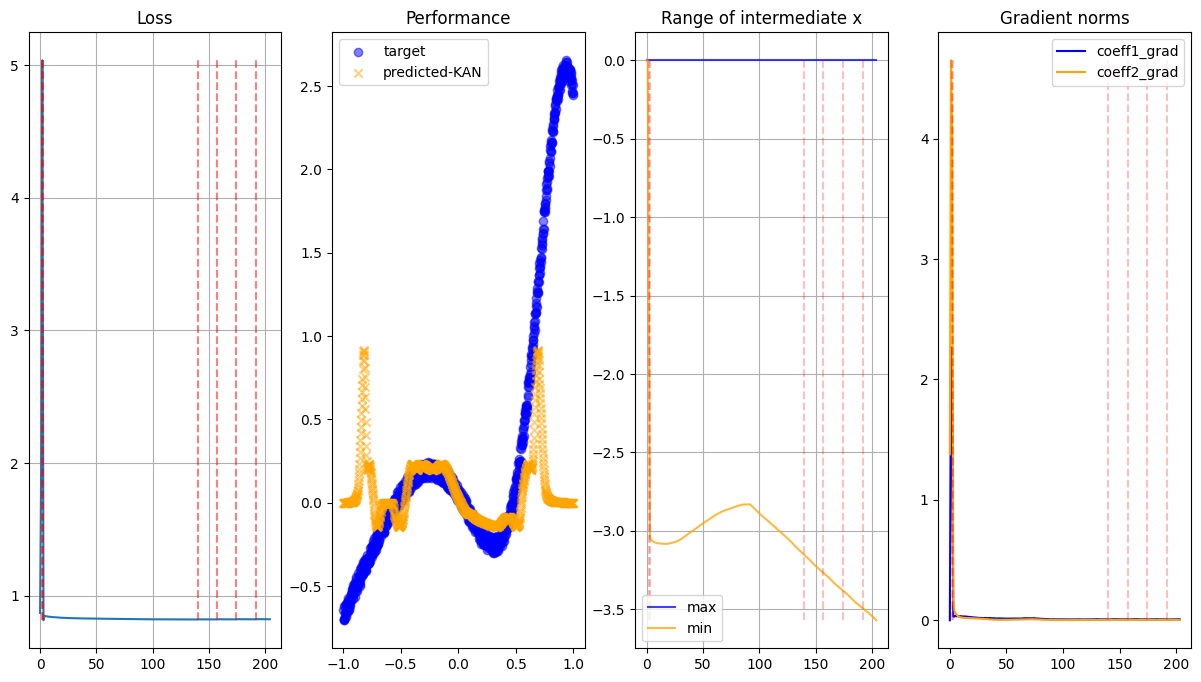

In [458]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 8), dpi=100)

ax = axs[0]
ax.plot(losses)
for i in grid_updates:
    ax.vlines(i, min(losses), max(losses), linestyle='--', alpha=0.5, color='red')
ax.grid()
ax.set_title(f"Loss")

ax = axs[1]
ax.scatter(x_eval[:, 0].tolist(), y_target[:, 0].tolist(), color='blue', alpha=0.5, label='target')
ax.scatter(x_eval[:, 0].tolist(), y_pred[:, 0].tolist(), color='orange', alpha=0.5, label='predicted-KAN', marker='x')
ax.legend()
ax.set_title(f"Performance")

ax = axs[2]
x_min = [xs[0].min().item() for xs in all_xs]
x_max = [xs[0].max().item() for xs in all_xs]
ax.plot(x_max, color='blue', alpha=0.75, label='max')
ax.plot(x_min, color='orange', alpha=0.75, label='min')

for i in grid_updates:
    ax.vlines(i, min(x_min), max(x_max), linestyle='--', alpha=0.25, color='red')

ax.legend()
ax.grid()
ax.set_title(f"Range of intermediate x")

ax = axs[3]
coeff1_grad = [x for x,_ in all_grads ]
coeff2_grad = [x for _,x in all_grads]
ax.plot(coeff1_grad, color='blue', alpha=1, label='coeff1_grad')
ax.plot(coeff2_grad, color='orange', alpha=1, label='coeff2_grad')
for i in grid_updates:
    ax.vlines(i, 0, max(max(coeff1_grad), max(coeff2_grad)), linestyle='--', alpha=0.25, color='red')

ax.legend()
ax.set_title(f"Gradient norms")


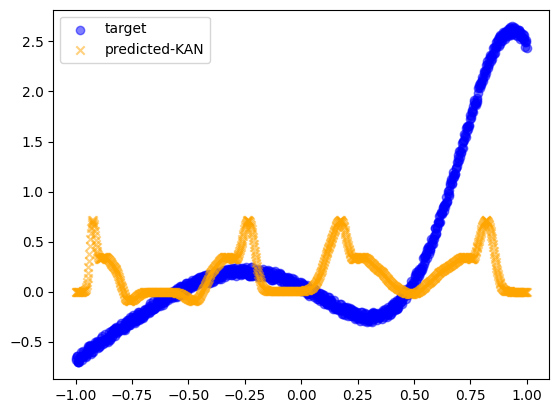

In [380]:
plt.scatter(x_eval[:, 0].tolist(), y_target[:, 0].tolist(), color='blue', alpha=0.5, label='target')
plt.scatter(x_eval[:, 0].tolist(), y_pred[:, 0].tolist(), color='orange', alpha=0.5, label='predicted-KAN', marker='x')
plt.legend()

In [251]:
# KAN training
fn = lambda x: torch.sin(torch.pi* torch.exp(x)) + torch.tanh(x) + torch.arcsinh(x)
x_eval = torch.linspace(-1, 1, steps=999).unsqueeze(dim=1)
y_target = fn(x_eval) + 0.1 * torch.rand(x_eval.shape)


lr = 0.1
k = 3
n_layers = 2
grid_sizes = [10, 10]

params_kan, y_pred_kan, losses_kan, [all_bases, all_xs] = single_stacked_kan_training(x_eval, y_target, lr=lr, k=k, n_layers=n_layers, grid_sizes=grid_sizes, verbose=False)
print(f"Number of parameters learned: {sum(x.numel() for x in params_kan)}")
print(f"Avg. loss: {np.mean(losses_kan[-100:]): 0.5f}")

Number of parameters learned: 12
Avg. loss:  0.25153


We see that the input to the final KAN layer is out of its control points (-1, 1) in this case. How do we deal with this situation?


Several things to note here -- 

1. 

Let's look at what would MLP do in this case?


In [80]:
# let's do it for two dimensions

# Let's see it in action
k = 2
x_eval = torch.rand((20, 2)) # each point is a sample
grid = torch.linspace(-1, 1, steps=10).unsqueeze(dim=0) # there is only one spline here 

bases = eval_basis_functions(x_eval, grid, k)
print("bases shape: ", bases.shape)

fn = lambda x: torch.sin(torch.pi * torch.exp(x)).sum(-1)
y_eval = fn(x_eval) + torch.randn(x_eval.shape[0])

# returns coeff for each dimension
coeff = torch.linalg.lstsq(bases.transpose(0, 1), y_eval.unsqueeze(dim=0)).solution # number of dimension x number of coefficients, 1
y_pred = torch.einsum('ijk, bij->bk', coeff, bases)
plt.scatter(x_eval[:, 0], y_eval[:, 0], alpha=0.5)
plt.scatter(x_eval[:, 0], y_pred[:, 0], marker='x', color='green', alpha=0.5)

print("Shapes:")
print(f"Input bases: {bases.transpose(0, 1).shape}")
print(f"Y_eval: {y_eval.unsqueeze(dim=0).shape}")
print(f"Ceofficients: {coeff.shape}")

bases shape:  torch.Size([20, 2, 7])


RuntimeError: input.size(-2) == other_2d.size(-2) INTERNAL ASSERT FAILED at "/Users/runner/work/_temp/anaconda/conda-bld/pytorch_1712608633180/work/aten/src/ATen/native/BatchLinearAlgebra.cpp":3356, please report a bug to PyTorch. 